In [1]:
!pip install albumentations


  Using cached eval_type_backport-0.3.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/40.1 MB ? eta -:--:--
    --------------------------------------- 0.5/40.1 MB 2.8 MB/s eta 0:00:15
   - -------------------------------------- 1.3/40.1 MB 3.5 MB/s eta 0:00:11
   - -------------------------------------- 1.8/40.1 MB 3.5 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/40.1 MB 3.2 MB/s eta 0:00:12
   --- ------------------------------------ 3.1/40.1 MB 3.2 MB/s eta 0:00:12
   --- ------------------------------------ 3.9/40.1 MB 3.3 MB/s eta 0:00:12
   ---- ----------------------------------- 4.7/40.1 MB 3.4 MB/s eta 0:00:11
   ----- ---------------------------------- 5.2/40.1 MB 3.4 MB/s eta 0:00:11
   ----- ---------------------------------- 5.8/40.1 MB 3.3 MB/s eta 0:00:11
   ------ ---------------

In [2]:
import os


import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from unet import build_unet
from tensorflow.keras.metrics import Precision, Recall
 
import random
import albumentations as A


# from metrics import dice_loss, dice_coef
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


In [4]:
print(tf.sysconfig.get_build_info())


OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [5]:
import tensorflow as tf

print("GPU in use:", tf.test.gpu_device_name())

GPU in use: /device:GPU:0


In [6]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print(details)

{'device_name': 'NVIDIA GeForce RTX 4050 Laptop GPU', 'compute_capability': (8, 9)}


In [7]:
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU available')
else:
    print('GPU not available')
tf.config.list_physical_devices('GPU')

GPU available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import tensorflow as tf

# List logical devices (after setting visible devices)
logical_gpus = tf.config.list_logical_devices('GPU')
print("Logical GPUs:", logical_gpus)

Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [9]:
tf.debugging.set_log_device_placement(False)

In [10]:
H = 256
W = 256

In [11]:

# Set a global seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [12]:
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

In [13]:
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x


from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(x, num_filters, dropout_rate=0.0, reg=1e-4):
    x = Conv2D(
        num_filters,
        3,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(reg)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    x = Conv2D(
        num_filters,
        3,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(reg)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x


def encoder_block(inputs, num_filters, dropout_rate):
    x = conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(inputs, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)
    return x

    
# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     # print(s1.shape, s2.shape, s3.shape, s4.shape)
#     # print(p1.shape, p2.shape, p3.shape, p4.shape)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="UNET")
#     return model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder (low dropout)
    s1, p1 = encoder_block(inputs, 32, 0.0)
    s2, p2 = encoder_block(p1, 64, 0.1)
    s3, p3 = encoder_block(p2, 128, 0.2)

    # Bottleneck (highest dropout)
    b1 = conv_block(p3, 256, dropout_rate=0.4)

    # Decoder (moderate dropout)
    d1 = decoder_block(b1, s3, 128, 0.2)
    d2 = decoder_block(d1, s2, 64, 0.1)
    d3 = decoder_block(d2, s1, 32, 0.0)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="UNET_Optimized")
    return model


if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [14]:
# def read_mask(path):
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     if x is None:
#         raise ValueError(f"Mask not found or unreadable: {path}")
#     x = cv2.resize(x, (W, H))
#     return x
# print(read_mask("C:\Projects Datasets\Segmentation_1\Segmentation_filtered\\masks"))

In [15]:
# Albumentations pipeline
transform = A.Compose([
    A.ElasticTransform(
        alpha=120,
        sigma=120 * 0.05,
        alpha_affine=120 * 0.03,
        p=0.5
    ),
    A.CLAHE(
        clip_limit=4.0,
        tile_grid_size=(8, 8),
        p=0.5
    ),
])


C:\Users\chanu\AppData\Local\Temp\ipykernel_21536\2050547636.py:3: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(


In [16]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# def load_dataset(path, split=0.2):
#     images = sorted(glob(os.path.join(path, "images", "*.png")))
#     masks = sorted(glob(os.path.join(path, "masks", "*.png")))

#     split_size = int(len(images) * split)

#     train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
def load_dataset(path, split=0.2, max_samples=None):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks  = sorted(glob(os.path.join(path, "masks", "*.png")))

    assert len(images) == len(masks), "Images and masks count mismatch"

    # 🔹 Limit dataset size
    if max_samples is not None:
        images = images[:max_samples]
        masks  = masks[:max_samples]

    # 🔹 Train / temp split
    train_x, temp_x, train_y, temp_y = train_test_split(
        images, masks,
        test_size=2 * split,
        random_state=42,
        shuffle=True
    )

    # 🔹 Validation / Test split
    valid_x, test_x, valid_y, test_y = train_test_split(
        temp_x, temp_y,
        test_size=0.5,
        random_state=42
    )

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y, training=False):

    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)

        if training:
            augmented = transform(image=x, mask=y)
            x = augmented["image"]
            y = augmented["mask"]

        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=2, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))

    dataset = dataset.map(
        lambda x, y: tf_parse(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 12
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("C:\\Projects Datasets\\model_details\\unet_6", "model_2.h5")
    csv_path = os.path.join("C:\\Projects Datasets\\model_details\\unet_6", "log.csv")

    """ Dataset """
    # dataset_path = "C:\\Projects Datasets\\Segmentation_1\\Segmentation_filtered"
    dataset_path="C:\Projects Datasets\Segmentation_1\Segmentation"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path,0.2,1500)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size, training=True)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size, training=False)
    test_dataset  = tf_dataset(test_x, test_y, batch=batch_size, training=False)


    """ Model """
    model = build_unet((H, W, 3))
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef])
    model.compile( loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef, Precision(name="precision"), Recall(name="recall")] )

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=valid_dataset,
        callbacks=callbacks
    )




Train: 900 - 900
Valid: 300 - 300
Test : 300 - 300
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.2065 - accuracy: 0.7903 - dice_coef: 0.0481 - precision: 0.0363 - recall: 0.5368
Epoch 1: val_loss improved from inf to 1.20272, saving model to C:\Projects Datasets\model_details\unet_6\model_2.h5
75/75 [==============================] - 63s 352ms/step - loss: 1.2065 - accuracy: 0.7903 - dice_coef: 0.0481 - precision: 0.0363 - recall: 0.5368 - val_loss: 1.2027 - val_accuracy: 0.8824 - val_dice_coef: 0.0276 - val_precision: 0.0252 - val_recall: 0.2048 - lr: 1.0000e-04
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 1.1324 - accuracy: 0.8405 - dice_coef: 0.0858 - precision: 0.0642 - recall: 0.7545
Epoch 2: val_loss improved from 1.20272 to 1.18201, saving model to C:\Projects Datasets\model_details\unet_6\model_2.h5
75/75 [==============================] - 28s 346ms/step - loss: 1.1324 - accuracy: 0.8405 - dice_coef: 0.0858 - precision: 0.0642 - 

In [17]:
""" Evaluate on test set """
results = model.evaluate(test_dataset)
print("\nEvaluation Metrics:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value:.4f}")

25/25 [==============================] - 3s 108ms/step - loss: 0.5620 - accuracy: 0.9908 - dice_coef: 0.6035 - precision: 0.8270 - recall: 0.5235

Evaluation Metrics:
loss: 0.5620
accuracy: 0.9908
dice_coef: 0.6035
precision: 0.8270
recall: 0.5235


In [18]:

import pickle
with open("C:\\Projects Datasets\\model_details\\unet_6\\history2.pkl", "wb") as f:
    pickle.dump(history.history, f)


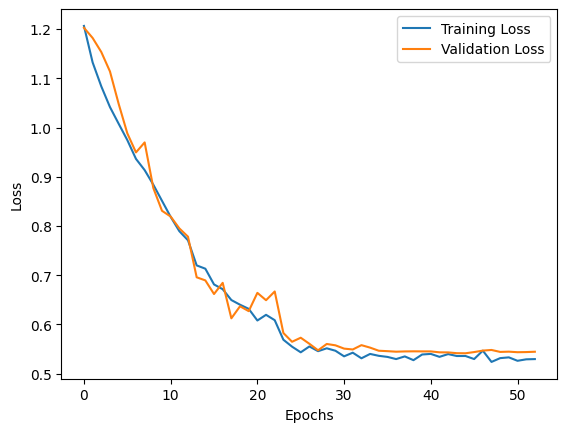

In [19]:
import pickle
import matplotlib.pyplot as plt

with open("C:\\Projects Datasets\\model_details\\unet_6\\history2.pkl", "rb") as f:
    history_dict = pickle.load(f)

plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


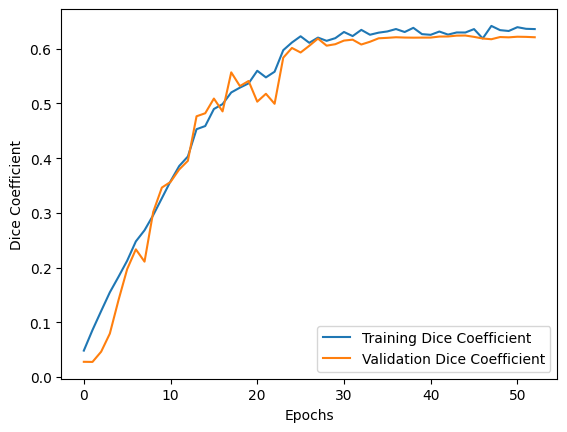

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_dict['dice_coef'], label='Training Dice Coefficient')
plt.plot(history_dict['val_dice_coef'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


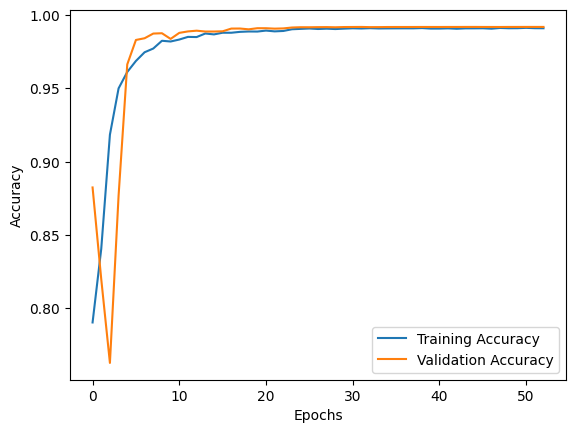

In [21]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
print("Final Training Dice:", history_dict['dice_coef'][-1])
print("Final Validation Dice:", history_dict['val_dice_coef'][-1])
# print(history_dict['accuracy'][-1]



Final Training Dice: 0.6360353231430054
Final Validation Dice: 0.6210829019546509


In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

model = load_model(
    "C:\\Projects Datasets\\model_details\\unet_6\\model_2.h5",
    custom_objects={"dice_coef": dice_coef},
    compile=False
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",  # or dice_loss
    metrics=["accuracy", dice_coef]
)

loss, accuracy, dice = model.evaluate(test_dataset)

print(f"Loss is {loss}")
print(f"Accuracy is {accuracy}")
print(f"Dice_Coef is {dice}")


25/25 [==============================] - 4s 110ms/step - loss: 0.2204 - accuracy: 0.9908 - dice_coef: 0.6063
Loss is 0.220352903008461
Accuracy is 0.9907944798469543
Dice_Coef is 0.6062895059585571


In [24]:
!pip install pandas


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log
csv_path = "C:\\Projects Datasets\\model_details\\unet_6\\log.csv"
log_data = pd.read_csv(csv_path)

# Inspect available columns
print(log_data.columns)


Index(['epoch', 'accuracy', 'dice_coef', 'loss', 'lr', 'precision', 'recall',
       'val_accuracy', 'val_dice_coef', 'val_loss', 'val_precision',
       'val_recall'],
      dtype='object')


In [26]:
#https://github.com/nikhilroxtomar/Brain-Tumor-Segmentation-in-TensorFlow-2.0

In [27]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )


In [28]:
model = load_model("C:\\Projects Datasets\\model_details\\unet_6\\model_2.h5",
                   custom_objects={"dice_coef": dice_coef},
                   compile=False)


In [29]:
import cv2
import numpy as np

# Load image
img_path = "C:\\Projects Datasets\\model_details\\1111.jpg"
image = cv2.imread(img_path)              # BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Resize to model input size
image_resized = cv2.resize(image, (256, 256))

# Normalize to [0,1]
image_norm = image_resized / 255.0

# Add batch dimension
input_tensor = np.expand_dims(image_norm, axis=0)   # shape (1, 256, 256, 3)


In [30]:
pred_mask = model.predict(input_tensor)

# Remove batch dimension
pred_mask = pred_mask[0]

# Threshold (convert probabilities to binary mask)
binary_mask = (pred_mask > 0.5).astype(np.uint8)


1/1 [==============================] - 1s 712ms/step


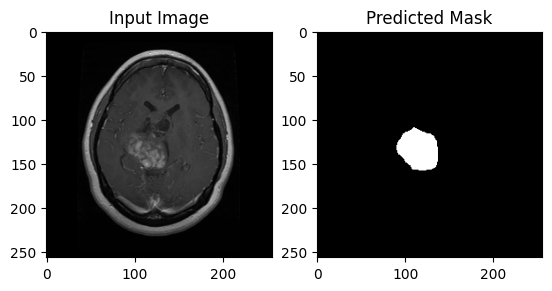

In [31]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()
